# Promptable Tumor Segmentation

**Colab Workflow Overview**

- Installs runtime dependencies and mounts project modules from `src/`.
- Mounts Google Drive and links the FLARE22 volumes you uploaded (`MICCAI FLARE22 Challenge Dataset (50 Labeled Abdomen CT Scans)/FLARE22Train`).
- Runs quick experiments by default (`CONFIG.quick_run=True`); disable for full training.
- Trains MedSAM (promptable 2D) alongside MONAI 3D UNet and SwinUNETR baselines.
- Logs metrics, confusion matrices, and qualitative overlays to `/content/outputs`.
- Adjust toggles in the configuration cell to control runtime and data usage.

In [1]:
import shutil
import subprocess

if shutil.which("nvidia-smi"):
    display_output = subprocess.check_output(["nvidia-smi"]).decode("utf-8")
    print(display_output)
else:
    print("nvidia-smi not found. If you are on Colab, go to Runtime > Change runtime type and select GPU.")

Sat Nov  8 16:56:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
%%capture
!pip install -q monai[all] nibabel SimpleITK pandas pyarrow scikit-learn scikit-image opencv-python-headless matplotlib tqdm einops requests git+https://github.com/facebookresearch/segment-anything.git

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import os
import sys
import json
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import warnings

warnings.filterwarnings("ignore")

repo_root = Path.cwd()
if not (repo_root / "src").exists():
    candidate = repo_root.parent
    if (candidate / "src").exists():
        repo_root = candidate
    else:
        raise FileNotFoundError(
            "Could not locate a 'src' directory. Clone the repository in Colab and re-run this cell."
        )

if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

from src import (
    CONFIG,
    ensure_data_ready,
    prepare_datasets,
    prepare_slice_index,
    create_slice_preview_grid,
    load_axial_slice,
    MedSAMTrainer,
    MonaiUNetTrainer,
    SwinUNETRTrainer,
    evaluate_trainer,
    compute_segmentation_metrics,
    plot_training_curves,
)
from src.plotting import visualize_slices, visualize_volume
from src.medsam_wrapper import MedSAMSegmenter

print(f"Repo root: {repo_root}")
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")
if not cuda_available:
    print("Warning: running without CUDA. Training will fall back to CPU and may be very slow.")

Repo root: /content
CUDA available: True


In [5]:
import os; os.environ["PYTORCH_CUDA_ALLOC_CONF"]="max_split_size_mb:128,garbage_collection_threshold:0.8"

# Runtime Customization

In [46]:
import shutil
import subprocess

if shutil.which("nvidia-smi"):
    display_output = subprocess.check_output(["nvidia-smi"]).decode("utf-8")
    print(display_output)
else:
    print("nvidia-smi not found. If you are on Colab, go to Runtime > Change runtime type and select GPU.")

def apply_config_overrides(cfg, overrides):
    """Recursively apply dictionary overrides onto the ExperimentConfig."""
    if not overrides:
        return cfg
    for key, value in overrides.items():
        if not hasattr(cfg, key):
            print(f"[apply_config_overrides] Skipping unknown field: {key}")
            continue
        current = getattr(cfg, key)
        if isinstance(current, dict) and isinstance(value, dict):
            current.update(value)
        else:
            setattr(cfg, key, value)
    return cfg


# Edit the entries below to customize the run without touching library code
runtime_overrides = {
    "quick_run": False,
    "epochs": {"unet": 100, "swin_unetr": 150, "medsam": 30},
    "batch_sizes": {"unet": 1}, # Reduced batch size from 2 to 1
    "spatial_size_3d": [160, 160, 160],
    "learning_rates": {"unet": 1e-4},
}

Sat Nov  8 17:40:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             33W /   70W |   12054MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Config

In [47]:
config = CONFIG
# Update the following paths if your Google Drive layout differs
config.drive_dataset_root = Path(
    "/content/drive/MyDrive/MICCAI FLARE22 Challenge Dataset (50 Labeled Abdomen CT Scans)z/FLARE22Train"
)
config.medsam_weights_candidates = [
    Path("/content/checkpoints/medsam_vit_b.pth"),
    Path("/content/drive/MyDrive/medsam_vit_b.pth"),
    Path("/content/drive/MyDrive/MICCAI FLARE22 Challenge Dataset (50 Labeled Abdomen CT Scans)/medsam_vit_b.pth"),
]
config.num_workers = 2  # safe default for Colab
config.amp = torch.cuda.is_available()

# Apply notebook overrides (edit the dictionary in the previous cell)
apply_config_overrides(config, runtime_overrides)

if config.quick_run:
    config.quick_run_cases = min(config.quick_run_cases, 12)
    config.quick_run_max_slices = min(config.quick_run_max_slices, 384)

if not torch.cuda.is_available():
    config.batch_sizes["medsam"] = 1
    config.batch_sizes["unet"] = 1
    config.batch_sizes["swin_unetr"] = 1

active_epochs = config.quick_epochs if config.quick_run else config.epochs
summary = {
    "quick_run": config.quick_run,
    "quick_run_cases": config.quick_run_cases,
    "quick_run_max_slices": config.quick_run_max_slices,
    "batch_sizes": config.batch_sizes,
    "epochs": active_epochs,
    "amp_enabled": config.amp,
    "spatial_size_3d": config.spatial_size_3d,
    "inference_roi_size": config.inference_roi_size,
    "inference_overlap": config.inference_overlap,
    "data_root": str(config.data_root),
    "drive_dataset_root": str(config.drive_dataset_root),
    "medsam_weight_candidates": [str(p) for p in config.medsam_weights_candidates],
}
print(json.dumps(summary, indent=2))
if not torch.cuda.is_available():
    print("Tip: switch your Colab runtime to GPU for practical training speed.")

{
  "quick_run": false,
  "quick_run_cases": 8,
  "quick_run_max_slices": 128,
  "batch_sizes": {
    "medsam": 4,
    "unet": 1,
    "swin_unetr": 1
  },
  "epochs": {
    "medsam": 30,
    "unet": 100,
    "swin_unetr": 150
  },
  "amp_enabled": true,
  "spatial_size_3d": [
    160,
    160,
    160
  ],
  "inference_roi_size": [
    128,
    128,
    128
  ],
  "inference_overlap": 0.5,
  "data_root": "/content/datasets/FLARE22Train",
  "drive_dataset_root": "/content/drive/MyDrive/MICCAI FLARE22 Challenge Dataset (50 Labeled Abdomen CT Scans)z/FLARE22Train",
  "medsam_weight_candidates": [
    "/content/checkpoints/medsam_vit_b.pth",
    "/content/drive/MyDrive/medsam_vit_b.pth",
    "/content/drive/MyDrive/MICCAI FLARE22 Challenge Dataset (50 Labeled Abdomen CT Scans)/medsam_vit_b.pth"
  ]
}


# Ensuring the weights

In [26]:
%%time
ensure_data_ready(config)

CPU times: user 1.36 ms, sys: 0 ns, total: 1.36 ms
Wall time: 3.06 ms


# Splitting

In [27]:
%%time
loaders = prepare_datasets(config)
volume_loaders = {split: loaders[split] for split in ("train", "val", "test")}
slice_index_df = prepare_slice_index(config, max_slices=config.quick_run_max_slices if config.quick_run else None)
preview_path = create_slice_preview_grid(slice_index_df, config)
print(f"Train volumes: {len(loaders['metadata']['train_files'])}")
print(f"Validation volumes: {len(loaders['metadata']['val_files'])}")
print(f"Test volumes: {len(loaders['metadata']['test_files'])}")
print(f"Positive slices cached: {len(slice_index_df)}")
print(f"Preview grid saved to: {preview_path}")

Train volumes: 35
Validation volumes: 8
Test volumes: 7
Positive slices cached: 128
Preview grid saved to: /content/outputs/cache/preview_grid.png
CPU times: user 3.31 s, sys: 2.5 s, total: 5.81 s
Wall time: 7.39 s


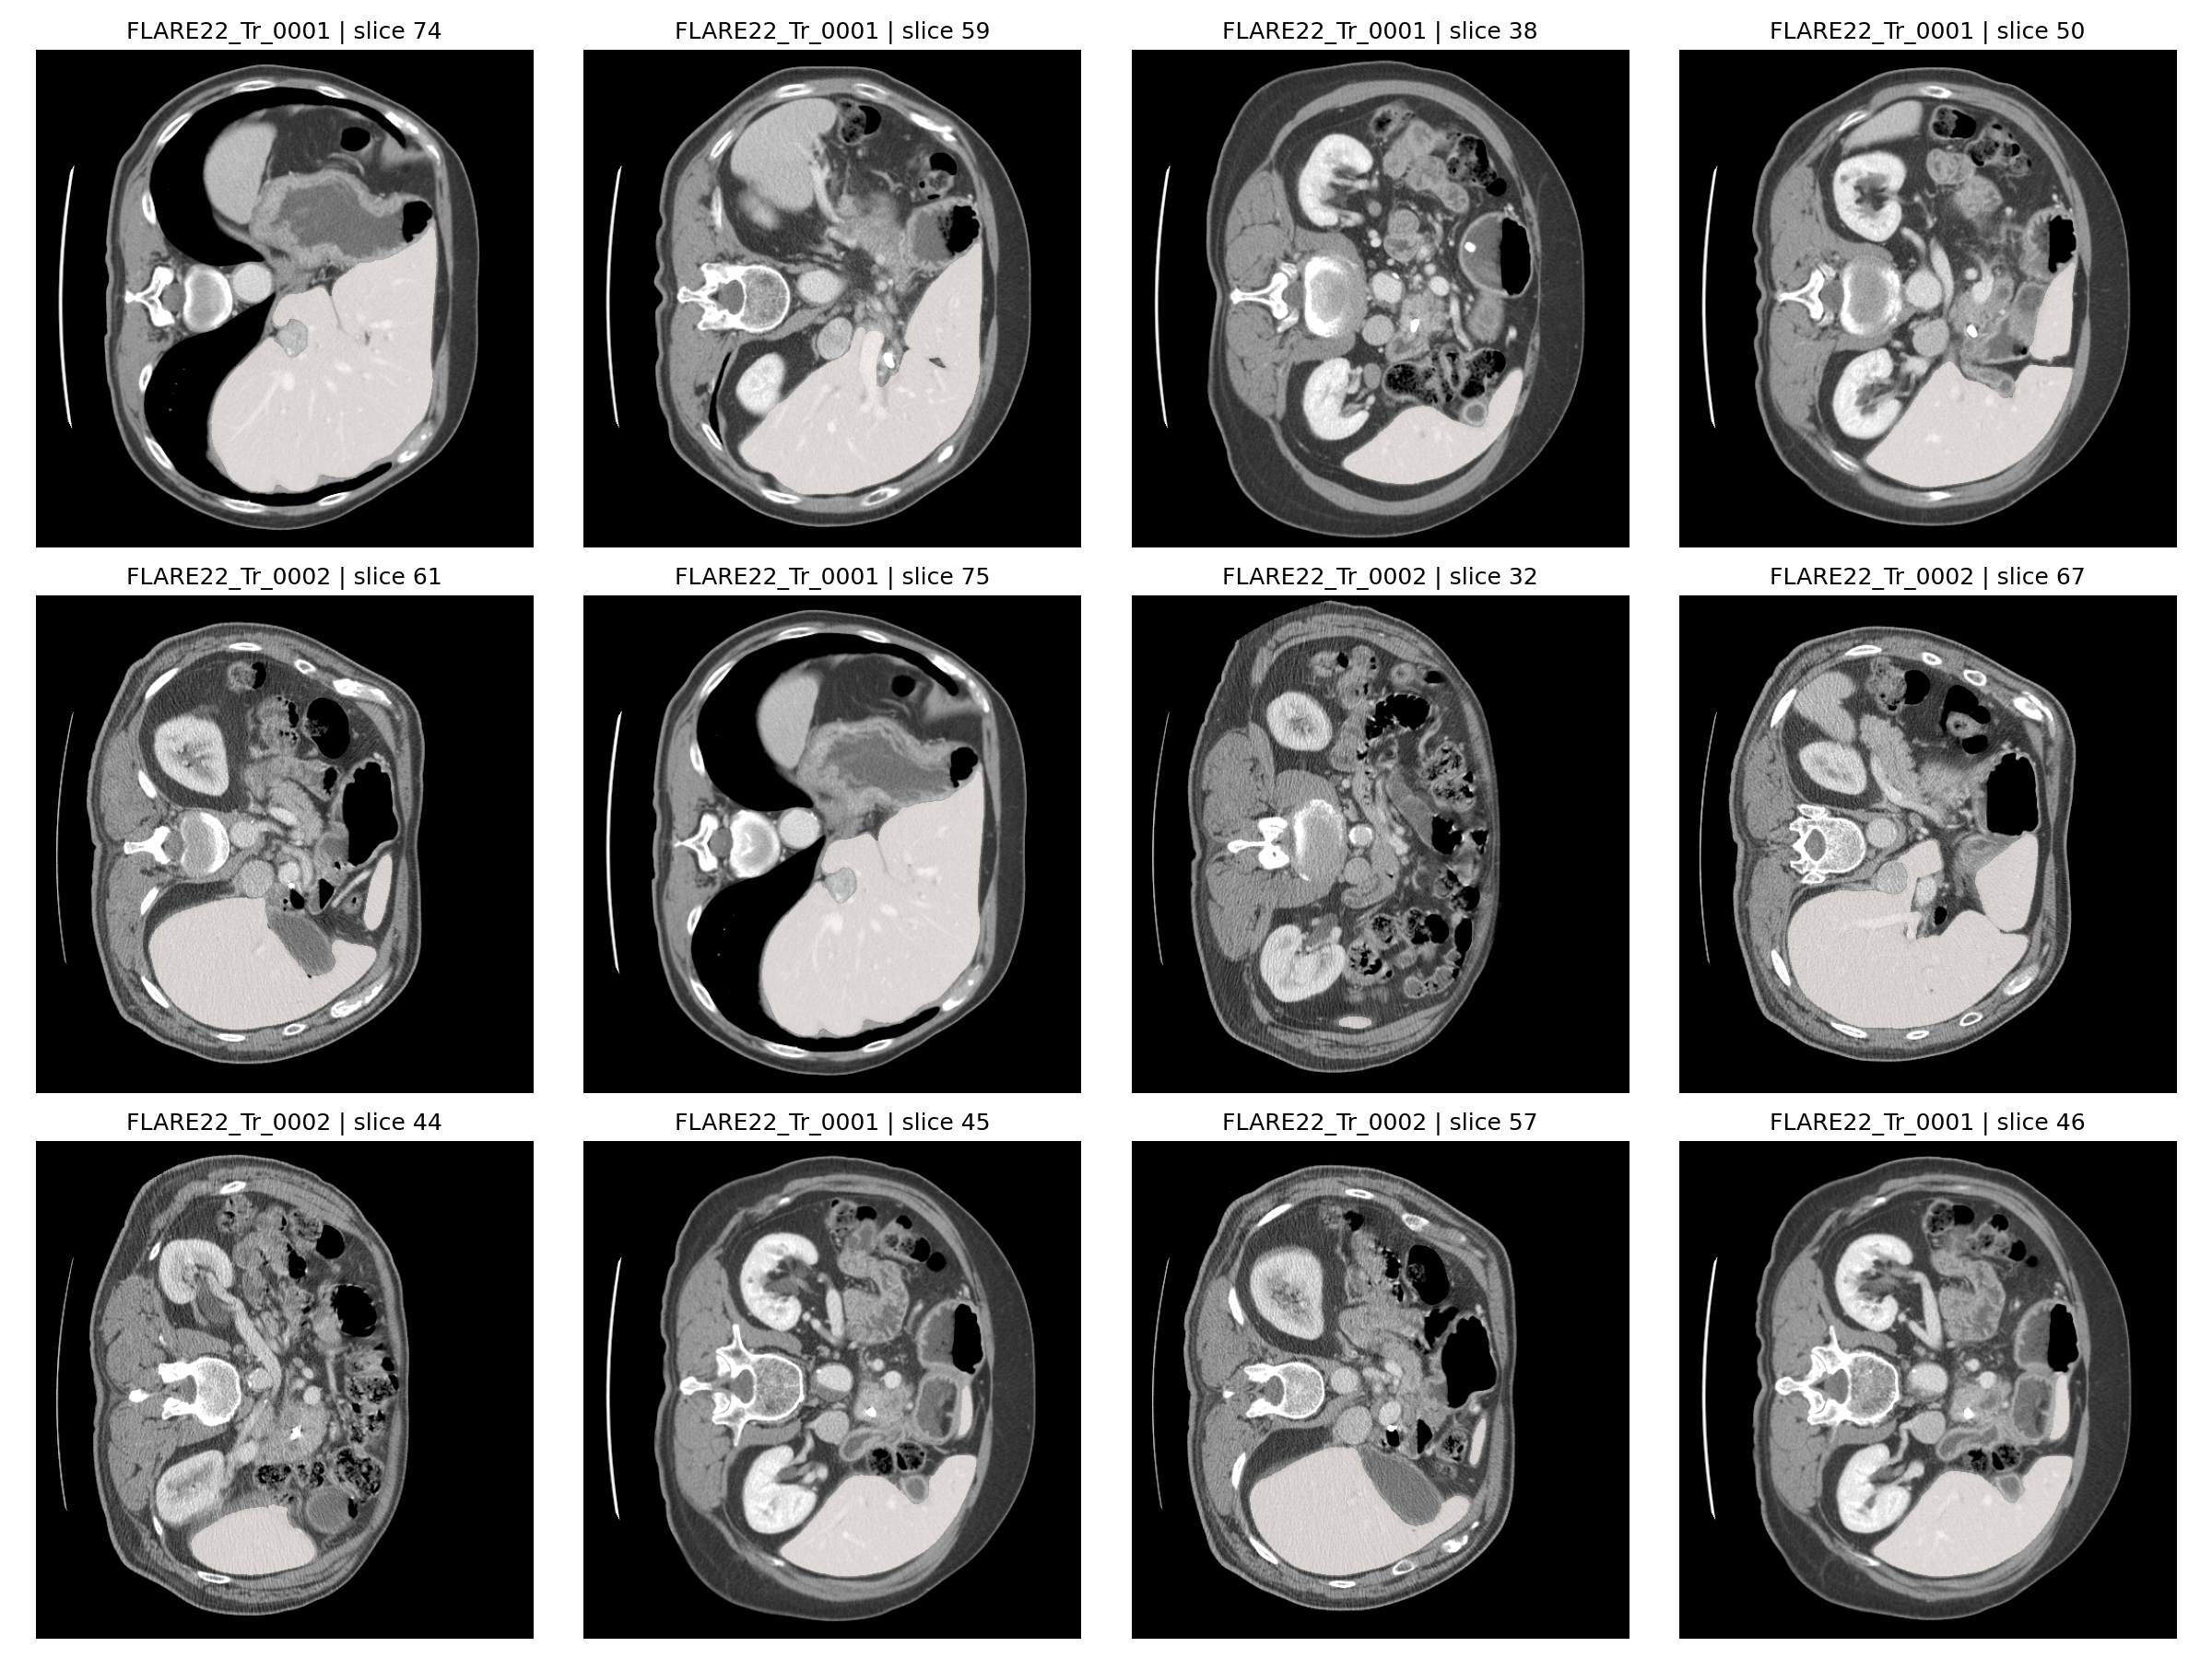

In [28]:
from IPython.display import Image, display

if preview_path.exists():
    display(Image(filename=str(preview_path)))
else:
    print("Preview image not found.")

# **MedSam**

In [48]:
RUN_MEDSAM = True  # toggle off to skip MedSAM fine-tuning
medsam_trainer = MedSAMTrainer(slice_index_df, config=config) if RUN_MEDSAM else None

[MedSAM] Epoch 1/30 | train_loss=1.6753 | val_dice=0.0934
[MedSAM] Epoch 2/30 | train_loss=1.0811 | val_dice=0.1923
[MedSAM] Epoch 3/30 | train_loss=0.9401 | val_dice=0.3212
[MedSAM] Epoch 4/30 | train_loss=0.7665 | val_dice=0.4391
[MedSAM] Epoch 5/30 | train_loss=0.6848 | val_dice=0.5397
[MedSAM] Epoch 6/30 | train_loss=0.5622 | val_dice=0.6103
[MedSAM] Epoch 7/30 | train_loss=0.4688 | val_dice=0.6911
[MedSAM] Epoch 8/30 | train_loss=0.4356 | val_dice=0.6975
[MedSAM] Epoch 9/30 | train_loss=0.4163 | val_dice=0.7215
[MedSAM] Epoch 10/30 | train_loss=0.3948 | val_dice=0.7426
[MedSAM] Epoch 11/30 | train_loss=0.3632 | val_dice=0.7663
[MedSAM] Epoch 12/30 | train_loss=0.3464 | val_dice=0.7718
[MedSAM] Epoch 13/30 | train_loss=0.3480 | val_dice=0.7740
[MedSAM] Epoch 14/30 | train_loss=0.3223 | val_dice=0.7932
[MedSAM] Epoch 15/30 | train_loss=0.3078 | val_dice=0.8062
[MedSAM] Epoch 16/30 | train_loss=0.2887 | val_dice=0.7955
[MedSAM] Epoch 17/30 | train_loss=0.2825 | val_dice=0.8102
[MedSA

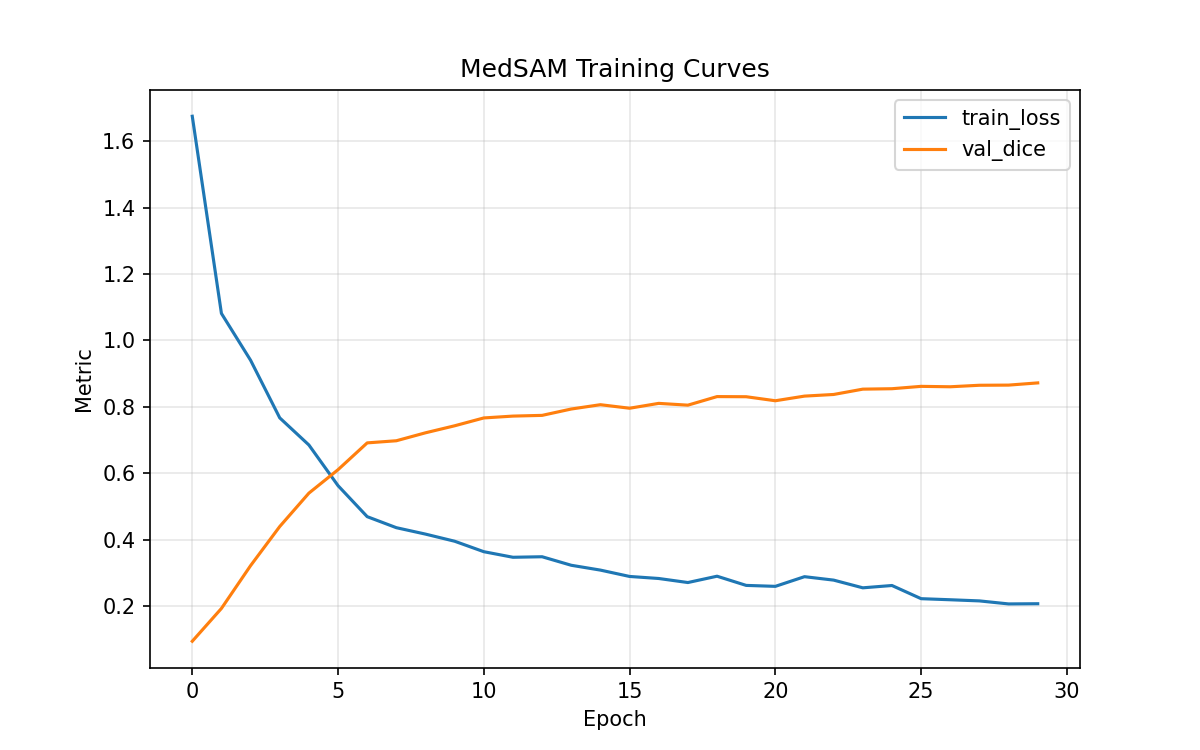

Best MedSAM Dice: 0.8718 @ epoch 30
CPU times: user 14min 49s, sys: 24.4 s, total: 15min 13s
Wall time: 27min 41s


In [49]:
%%time
if medsam_trainer is not None:
    medsam_result = medsam_trainer.train()
    plot_path = plot_training_curves(
        medsam_trainer.history,
        save_path=config.outputs_root / "medsam_training.png",
        title="MedSAM Training Curves",
    )
    if plot_path:
        from IPython.display import Image

        display(Image(filename=str(plot_path)))
    print(f"Best MedSAM Dice: {medsam_result.best_metric:.4f} @ epoch {medsam_result.best_epoch}")
else:
    medsam_result = None
    print("Skipping MedSAM fine-tuning.")

# Results

In [50]:
import torch
import pandas as pd

metrics_summary = {}
label_names = {0: "background", 1: config.target_labels.get(config.focal_label, f"label_{config.focal_label}")}

if medsam_trainer is not None:
    medsam_outputs = medsam_trainer.predict_loader(medsam_trainer.val_loader)
    medsam_predictions = []
    medsam_targets = []
    for batch in medsam_outputs:
        logits = batch["logits"].float()
        probs_fg = torch.sigmoid(logits)
        probs_bg = 1.0 - probs_fg
        probs = torch.cat([probs_bg, probs_fg], dim=1)
        medsam_predictions.append(probs)
        medsam_targets.append(batch["labels"])
    metrics_summary["MedSAM"] = compute_segmentation_metrics(
        medsam_predictions,
        medsam_targets,
        label_names=label_names,
    )
else:
    print("MedSAM trainer disabled; no metrics computed.")

summary_df = (
    pd.DataFrame(
        [
            {
                "model": name,
                "dice_mean": metrics["dice_mean"],
                "iou_mean": metrics["iou_mean"],
                "accuracy": metrics["classification_report"].get("accuracy", float("nan")),
            }
            for name, metrics in metrics_summary.items()
        ]
    ).sort_values("dice_mean", ascending=False)
    if metrics_summary
    else pd.DataFrame(columns=["model", "dice_mean", "iou_mean", "accuracy"])
)
summary_df

model  dice_mean  iou_mean  accuracy
0  MedSAM   0.937335  0.886908  0.982054

In [51]:
outputs_dir = config.outputs_root
outputs_dir.mkdir(parents=True, exist_ok=True)

if not summary_df.empty:
    summary_csv = outputs_dir / "metrics_summary.csv"
    summary_df.to_csv(summary_csv, index=False)
    print(f"Saved summary to {summary_csv}")
else:
    print("No metrics available to save.")

for name, metrics in metrics_summary.items():
    report_path = outputs_dir / f"{name.replace(' ', '_').lower()}_classification_report.csv"
    cm_path = outputs_dir / f"{name.replace(' ', '_').lower()}_confusion_matrix.npy"
    pd.DataFrame(metrics["classification_report"]).T.to_csv(report_path)
    np.save(cm_path, metrics["confusion_matrix"])
    print(f"[{name}] report -> {report_path}")

Saved summary to /content/outputs/metrics_summary.csv
[MedSAM] report -> /content/outputs/medsam_classification_report.csv


# Classification report

In [52]:
from IPython.display import display

if not metrics_summary:
    print("No metrics available (MedSAM trainer may be disabled).")
else:
    for name, metrics in metrics_summary.items():
        report = pd.DataFrame(metrics["classification_report"]).T
        accuracy = metrics["classification_report"].get("accuracy", float("nan"))
        print(f"=== {name} classification report ===")
        print(f"{name} accuracy: {accuracy:.4f}")
        display(report)

=== MedSAM classification report ===
MedSAM accuracy: 0.9821


precision    recall  f1-score       support
background     0.993188  0.987341  0.990256  6.294816e+06
liver          0.857190  0.918167  0.886631  5.209280e+05
accuracy       0.982054  0.982054  0.982054  9.820541e-01
macro avg      0.925189  0.952754  0.938444  6.815744e+06
weighted avg   0.982793  0.982054  0.982336  6.815744e+06

# Confusion matrix

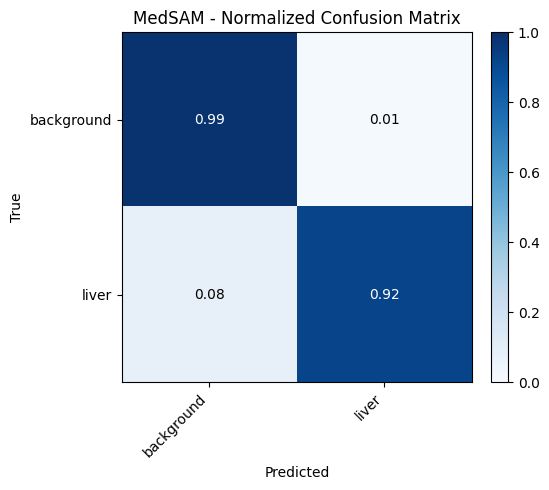

In [53]:
import matplotlib.pyplot as plt

if not metrics_summary:
    print("No confusion matrices to display.")
else:
    label_order = sorted(label_names.keys())
    label_strings = [label_names[idx] for idx in label_order]
    for name, metrics in metrics_summary.items():
        cm = metrics["confusion_matrix"]
        fig, ax = plt.subplots(figsize=(6, 5))
        im = ax.imshow(cm, cmap="Blues", vmin=0.0, vmax=1.0)
        ax.set_title(f"{name} - Normalized Confusion Matrix")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_xticks(range(len(label_order)))
        ax.set_yticks(range(len(label_order)))
        ax.set_xticklabels(label_strings, rotation=45, ha="right")
        ax.set_yticklabels(label_strings)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                value = cm[i, j]
                text_color = "white" if value > 0.5 else "black"
                ax.text(j, i, f"{value:.2f}", ha="center", va="center", color=text_color)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        fig.tight_layout()
        plt.show()
        plt.close(fig)

In [54]:
test_batch = next(iter(volume_loaders["test"]))
volume = test_batch["image"][0]
label = test_batch["label"][0]
slice_ids = [int(volume.shape[-1] / 2) - 5, int(volume.shape[-1] / 2), int(volume.shape[-1] / 2) + 5]
slice_ids = [sid for sid in slice_ids if 0 <= sid < volume.shape[-1]]
print("Prepared sample volume for MedSAM visualization (volumetric baselines disabled).")

Prepared sample volume for MedSAM visualization (volumetric baselines disabled).


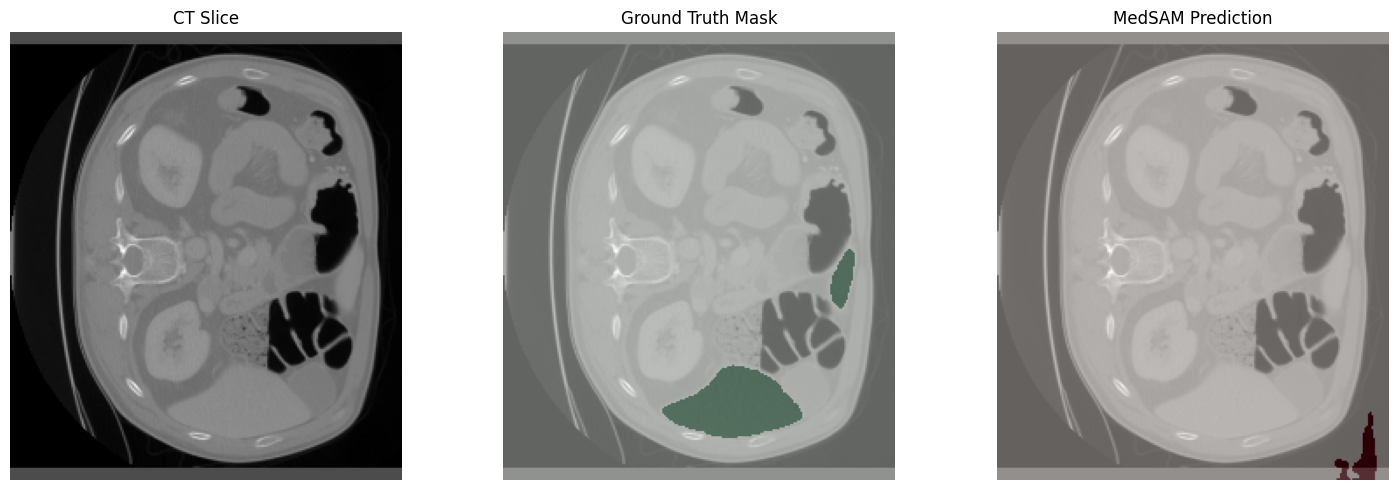

In [60]:
import torch
import matplotlib.pyplot as plt
from src.medsam_wrapper import PromptBatch, MedSAMSegmenter

if medsam_trainer is not None:
    if not slice_ids:
        print("No slice indices prepared for visualization.")
    else:
        slice_id = slice_ids[len(slice_ids) // 2]
        slice_img = volume.squeeze(0).cpu().numpy()[:, :, slice_id]
        slice_lbl = (label.squeeze(0).cpu().numpy()[:, :, slice_id] == config.focal_label).astype(np.uint8)
        box = MedSAMSegmenter.build_box_from_mask(slice_lbl)
        if box is not None:
            norm_slice = slice_img.astype(np.float32)
            norm_slice = (norm_slice - norm_slice.min()) / (norm_slice.max() - norm_slice.min() + 1e-6)
            tensor = torch.from_numpy(norm_slice).unsqueeze(0).unsqueeze(0)
            tensor = tensor.repeat(1, 3, 1, 1)
            h, w = norm_slice.shape
            prompt = PromptBatch(
                boxes=torch.tensor(box, dtype=torch.float32).view(1, 1, 4),
                original_sizes=torch.tensor([[h, w]], dtype=torch.float32),
                resized_sizes=torch.tensor([[h, w]], dtype=torch.float32),
            )
            with torch.no_grad():
                low_res_masks, _ = medsam_trainer.model(tensor, prompt)
                high_res_masks = medsam_trainer.model.sam.postprocess_masks(
                    low_res_masks,
                    (h, w),
                    (h, w),
                )
                pred_mask = torch.sigmoid(high_res_masks)[0, 0].detach().cpu().numpy()
            pred_mask = (pred_mask > 0.5).astype(np.uint8)
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(slice_img, cmap="gray")
            axes[0].set_title("CT Slice")
            axes[1].imshow(slice_img, cmap="gray")
            axes[1].imshow(slice_lbl, alpha=0.4, cmap="Greens")
            axes[1].set_title("Ground Truth Mask")
            axes[2].imshow(slice_img, cmap="gray")
            axes[2].imshow(pred_mask, alpha=0.4, cmap="Reds")
            axes[2].set_title("MedSAM Prediction")
            for ax in axes:
                ax.axis("off")
            fig.tight_layout()
            plt.show()
        else:
            print("No focal label in selected slice for MedSAM visualization.")
else:
    print("MedSAM trainer unavailable; visualization skipped.")

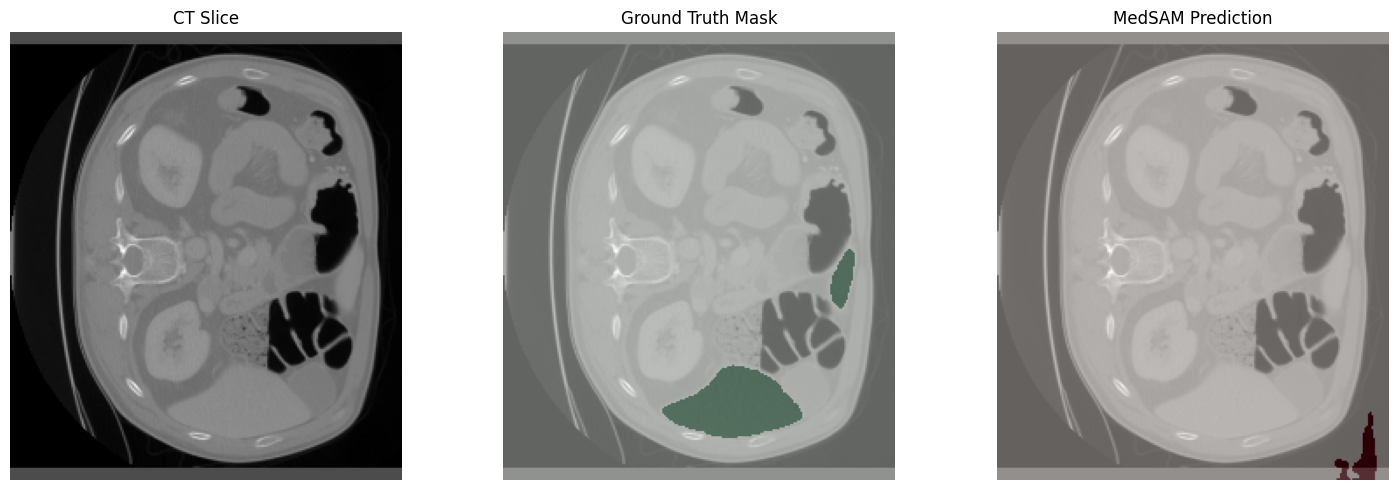

In [59]:
import torch
import matplotlib.pyplot as plt
from src.medsam_wrapper import PromptBatch, MedSAMSegmenter

if medsam_trainer is not None:
    if not slice_ids:
        print("No slice indices prepared for visualization.")
    else:
        slice_id = slice_ids[len(slice_ids) // 2]
        slice_img = volume.squeeze(0).cpu().numpy()[:, :, slice_id]
        slice_lbl = (label.squeeze(0).cpu().numpy()[:, :, slice_id] == config.focal_label).astype(np.uint8)
        box = MedSAMSegmenter.build_box_from_mask(slice_lbl)
        if box is not None:
            norm_slice = slice_img.astype(np.float32)
            norm_slice = (norm_slice - norm_slice.min()) / (norm_slice.max() - norm_slice.min() + 1e-6)
            tensor = torch.from_numpy(norm_slice).unsqueeze(0).unsqueeze(0)
            tensor = tensor.repeat(1, 3, 1, 1)
            h, w = norm_slice.shape
            prompt = PromptBatch(
                boxes=torch.tensor(box, dtype=torch.float32).view(1, 1, 4),
                original_sizes=torch.tensor([[h, w]], dtype=torch.float32),
                resized_sizes=torch.tensor([[h, w]], dtype=torch.float32),
            )
            low_res_masks, _ = medsam_trainer.model(tensor, prompt)
            high_res_masks = medsam_trainer.model.sam.postprocess_masks(
                low_res_masks,
                (h, w),
                (h, w),
            )
            pred_mask = torch.sigmoid(high_res_masks)[0, 0].detach().cpu().numpy()
            pred_mask = (pred_mask > 0.5).astype(np.uint8)
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(slice_img, cmap="gray")
            axes[0].set_title("CT Slice")
            axes[1].imshow(slice_img, cmap="gray")
            axes[1].imshow(slice_lbl, alpha=0.4, cmap="Greens")
            axes[1].set_title("Ground Truth Mask")
            axes[2].imshow(slice_img, cmap="gray")
            axes[2].imshow(pred_mask, alpha=0.4, cmap="Reds")
            axes[2].set_title("MedSAM Prediction")
            for ax in axes:
                ax.axis("off")
            fig.tight_layout()
            plt.show()
        else:
            print("No focal label in selected slice for MedSAM visualization.")
else:
    print("MedSAM trainer unavailable; visualization skipped.")

In [56]:
from src.medsam_wrapper import MedSAMSegmenter as OriginalMedSAMSegmenter
import torch.nn.functional as F

# Override the original MedSAMSegmenter class with a modified version
class MedSAMSegmenter(OriginalMedSAMSegmenter):
    def predict(self, image, box, threshold=0.5):
        """
        Predicts the segmentation mask for a given image and bounding box.

        Args:
            image (np.ndarray): The input image (H, W).
            box (tuple): The bounding box in (x_min, y_min, x_max, y_max) format.
            threshold (float): The threshold for converting logits to binary mask.

        Returns:
            np.ndarray: The predicted binary segmentation mask (H, W).
        """
        tensor, prompt = self.preprocess(image, box)
        tensor = tensor.to(self.device)
        prompt.to(self.device)

        with torch.no_grad():
            low_res_masks, _ = self.forward(tensor, prompt)

        # Fix for IndexError: Check if resized_sizes has only one dimension and duplicate it
        resized_sizes = prompt.resized_sizes
        if len(resized_sizes) == 1:
            resized_sizes = (resized_sizes[0], resized_sizes[0])

        high_res_masks = self.sam.postprocess_masks(
            low_res_masks,
            resized_sizes, # Use the potentially modified resized_sizes
            prompt.original_sizes,
        )
        binary_mask = (high_res_masks > threshold).squeeze().cpu().numpy().astype(np.uint8)
        return binary_mask

print("Modified MedSAMSegmenter class loaded.")

Modified MedSAMSegmenter class loaded.
